In [44]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

In [45]:
Nc = 5 # number of cells in each direction
D = 1.0 # initial cell diameter

K = 1
T = 1/30
gamma = -1/20

h = 0.001
n = 0.01

display_interval = 10

grow_c_i = [7]
grow_speed = 0.005

l_min = 0.05

In [46]:
def line_intersect(p, l, prev_p):
    # Calculate the slope and y-intercept of the line segment0ß
    x1, y1 = p[0]
    x2, y2 = p[1]
    k, d = l

    if x1 == x2:
        x = x1
        if min(y1, y2) <= (k*x + d) <= max(y1, y2):
            new_p = (x, k*x + d)
            for p in prev_p:
                if np.linalg.norm(new_p - p) < 0.1:
                    return [None]
                else:
                    return new_p

        else:
            return [None]

    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1


    # Calculate the x-coordinate of the intersection point
    x = (c - d) / (k - m)

    # Check if the intersection point lies within the line segment
    if min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= k*x + d <= max(y1, y2):
        # If it does, return the intersection point
        new_p = (x, k*x + d)
        # for p in prev_p:
        #     if np.linalg.norm(new_p - p) < 0.1:
        #         return [None]
        #     else:
        return new_p
    else:
        # If it doesn't, return None
        return [None]


In [47]:


class Vertex :
    def __init__ (self ,x, cell_i):
        self.x = x # position
        self.v = np.zeros(2)
        self.f = np.zeros(2) # force
        if type(cell_i) == list:
            self.cells = cell_i
        else:
            self.cells = [cell_i]
    def calc_f(self):
        d_U = 0
        for c in self.cells:
            c = cells[c]
            is_c_i = [vertices[v] == self for v in c.v]
            c_i = is_c_i.index(True)
            c_i_next = (c_i + 1) % len(c.v)
            c_i_prev = c_i - 1 if c_i > 0 else len(c.v) -1
            d_A = 0.5*(np.array([vertices[c.v[c_i_next]].x[1], vertices[c.v[c_i_prev]].x[0]]) - np.array([vertices[c.v[c_i_prev]].x[1], vertices[c.v[c_i_next]].x[0]]))
            if np.linalg.norm(vertices[c.v[c_i_prev]].x - vertices[c.v[c_i]].x) == 0 or np.linalg.norm(vertices[c.v[c_i_next]].x - vertices[c.v[c_i]].x) == 0:
                n1 = np.linalg.norm(vertices[c.v[c_i_prev]].x - vertices[c.v[c_i]].x)
                n2 = np.linalg.norm(vertices[c.v[c_i_next]].x - vertices[c.v[c_i]].x)
                print("0 length n1: ", n1, "n2: ", n2)
                print(c_i_prev, c_i, c_i_prev)
            d_P = -(vertices[c.v[c_i_prev]].x - vertices[c.v[c_i]].x)/np.linalg.norm(vertices[c.v[c_i_prev]].x - vertices[c.v[c_i]].x) -(vertices[c.v[c_i_next]].x - vertices[c.v[c_i]].x)/np.linalg.norm(vertices[c.v[c_i_next]].x - vertices[c.v[c_i]].x)
            d_U += K*(c.A - c.tA)*d_A + T*(c.P - c.tP)*d_P + gamma*d_P
        self.f = -d_U
    def update_velocity(self):
        self.v = self.f/n
    def update_position(self):
        self.x += h*self.v

class Cell :
    def __init__ (self):
        self.v = [] # indices of vertices belonging to this cell
        self.tA = 0
        self.divA = 2
        self.A = 0
        self.P = 0
        self.gs = random.random()
        self.tP = 1
    def calc_A(self):
        n_v = len(self.v)
        A = 0
        for i in range(n_v):
            i_next = (i + 1) % n_v
            A += vertices[self.v[i]].x[0]*vertices[self.v[i_next]].x[1] - vertices[self.v[i]].x[1]*vertices[self.v[i_next]].x[0]
        self.A = A/2
    def calc_P(self):
        n_v = len(self.v)
        P = 0
        for i in range(n_v):
            i_next = (i + 1) % n_v
            P += math.sqrt((vertices[self.v[i]].x[0] - vertices[self.v[i_next]].x[0])**2 + (vertices[self.v[i]].x[1] - vertices[self.v[i_next]].x[1])**2)
        self.P = P
    def div(self):
        global vertices
        global cells
        if self.A > self.divA:
            #Caluclate centroid
            c = np.zeros(2)
            # [plt.scatter(x[0], x[1], color = "blue") for x in [vertices[i].x for i in self.v]]
            # plt.plot([vertices[i].x[0] for i in self.v+[self.v[0]]], [vertices[i].x[1] for i in self.v+[self.v[0]]], color = "red")
            # plt.show()
            for i, v in enumerate(self.v):
                v_x = vertices[v].x
                next_v_x = vertices[self.v[(i + 1)%len(self.v)]].x
                c[0] += (v_x[0]*next_v_x[1] - next_v_x[0]*v_x[1])*(v_x[0] + next_v_x[0])
                c[1] += (v_x[0]*next_v_x[1] - next_v_x[0]*v_x[1])*(v_x[1] + next_v_x[1])
            c /= 6*self.A
            
            #Find the longest axis
            max_d_vp = [None, 0]
            for v1 in self.v:
                for v2 in self.v:
                    d = np.linalg.norm(vertices[v1].x - vertices[v2].x)
                    if d > max_d_vp[1]:
                        vec = vertices[v1].x - vertices[v2].x
                        k = -vec[0]/vec[1]
                        max_d_vp = [[k, c[1]-k*c[0]], d]
            # [plt.scatter(x[0], x[1], color = "blue") for x in [vertices[i].x for i in self.v]]
            # plt.plot([vertices[i].x[0] for i in self.v+[self.v[0]]], [vertices[i].x[1] for i in self.v+[self.v[0]]], color = "red")
            # plt.scatter(c[0], c[1], color = "green")
            # x_vals = np.linspace(c[0]-0.1, c[0]+0.1, 5)
            # plt.plot(x_vals, [max_d_vp[0][0]*x + max_d_vp[0][1] for x in x_vals])
            # plt.ylim(0, 5)
            # plt.show()

            inter_p = []
            found_i = False
            new_c_v = []
            old_c_v = []
            for i, v in enumerate(self.v):
                if found_i:
                    new_c_v.append(v)
                    vertices[v].cells.append(len(cells))
                    try:
                        vertices[v].cells.remove(cells.index(self))
                    except:
                        print("Vertices: ", v, "not found in cell: ", cells.index(self))
                else: 
                    old_c_v.append(v)
                v_x = vertices[v].x
                next_v_x = vertices[self.v[(i + 1)%len(self.v)]].x
                intersec = line_intersect([v_x, next_v_x] , max_d_vp[0], inter_p)
                if intersec[0]:
                    found_i = not found_i
                    inter_p.append(intersec)
                    new_c_v.append(len(vertices))
                    old_c_v.append(len(vertices))
                    neigh_c_v = list(set(vertices[v].cells) & set(vertices[self.v[(i + 1)%len(self.v)]].cells) - set([cells.index(self)]))
                    if neigh_c_v:
                        neigh_c_v = neigh_c_v[0]
                        if cells[neigh_c_v].v.index(v) == len(cells[neigh_c_v].v)-1 and cells[neigh_c_v].v.index(self.v[(i + 1)%len(self.v)]) == 0:
                            cells[neigh_c_v].v.insert(0, len(vertices)) 
                        elif cells[neigh_c_v].v.index(self.v[(i + 1)%len(self.v)]) == len(cells[neigh_c_v].v)-1 and cells[neigh_c_v].v.index(v) ==0:
                            cells[neigh_c_v].v.insert(0, len(vertices))
                        else:
                            first_i = min(cells[neigh_c_v].v.index(v), cells[neigh_c_v].v.index(self.v[(i + 1)%len(self.v)]))
                            cells[neigh_c_v].v.insert(first_i + 1, len(vertices))
                        cell_l = [cells.index(self), neigh_c_v, len(cells)]
                    else:
                        cell_l = [cells.index(self), len(cells)]
                    vertices.append(Vertex(np.array(intersec), cell_l))
            if found_i:
                print("Error - too many intersects found in div.")
            else:
                self.v = old_c_v
                self.tA /= 2
                self.tP /= 2
                cells.append(Cell())
                cells[-1].v = new_c_v
                cells[-1].tA = self.tA
                cells[-1].tP = self.tP
                grow_c_i.append(len(cells)-1)


In [48]:

# initialize the cells & vertices
cells = []
vertices = []
d = math.sqrt(3)/2 # ratio of inscribed to circumscribed circle diameters
for i in range (Nc):
    for j in range (Nc):
        cells.append (Cell())
        for k in range (6 ):
            x = np.array ([0.75*i , (j + 0.5*(i%2)) * d])
            x += np.array ([math.cos (k* math.pi/3 ) , math.sin( k* math.pi/3)]) / 2
            vertices.append ( Vertex (D * x, len(cells)-1))
            cells[-1].v.append(len(vertices )-1)
# merge vertices that are shared between cells
i = 0
while i < len(vertices):
    j = i+1
    while j < len(vertices):
        if np . linalg.norm(vertices [i]. x - vertices [j]. x) < D/ 100:
            for c in cells :    
                for k in range(len (c .v)):
                    if c.v[k] == j:
                        c.v[k] = i
                    elif c.v[k] > j:
                        c.v[k] -= 1
            vertices[i].cells += vertices[j].cells
            del vertices [j]
        else :
            j += 1
    i += 1
# add randomness
for v in vertices :
    v.x += D/10 * np.array ([ np.random.uniform (-1 , 1 ) , np.random.uniform (-1 , 1)])

for c in cells:
    n_v = len(c.v)
    tA = 0
    for i in range(n_v):
        i_next = (i + 1) % n_v
        tA += vertices[c.v[i]].x[0]*vertices[c.v[i_next]].x[1] - vertices[c.v[i]].x[1]*vertices[c.v[i_next]].x[0]
    tA /= 2
    c.tA = tA
    

In [49]:
def update_positions_and_velocities():
    for i, c in enumerate(cells):
        c.calc_A()
        c.calc_P()
        c.div()
        c.tA += c.gs * grow_speed
    for i, v in enumerate(vertices):
        v.calc_f()

    for v in vertices:
        v.update_velocity()
        v.update_position()
    # for g_c in grow_c_i:
    #     cells[g_c].tA += random.random() * grow_speed

    for c in cells:
        removed_edges = 0
        for i in range(len(c.v)):
            # get the indices of the two vertices that form an edge
            i_vertex = c.v[i - removed_edges]
            j_vertex = c.v[(i+1 - removed_edges)%len(c.v)]
            e = vertices[j_vertex].x - vertices[i_vertex].x
            if np.linalg.norm(e) < l_min:
                t_cells = [None, None, None, None]
                overlap = list(set(vertices[j_vertex].cells) & set(vertices[i_vertex].cells))
                if not overlap:
                    if vertices[j_vertex].cells == 1:
                        c.v.remove(j_vertex)
                    elif vertices[i_vertex].cells == 1:
                        c.v.remove(i_vertex)
                    else:
                        print("Error - could not remove lonely vertex in t1.")
                if len(overlap) == 2:
                    #This does not work if index[i] = [-1]
                    if cells[overlap[0]].v.index(i_vertex) < cells[overlap[0]].v.index(j_vertex) or (i_vertex == cells[overlap[0]].v[-1] and j_vertex == cells[overlap[0]].v[0]):
                        t_cells[0] = overlap[0]
                        t_cells[1] = overlap[1]
                    else:
                        t_cells[1] = overlap[0]
                        t_cells[0] = overlap[1]
                else: 
                    if cells[overlap[0]].v.index(i_vertex) < cells[overlap[0]].v.index(j_vertex) or (i_vertex == cells[overlap[0]].v[-1] and j_vertex == cells[overlap[0]].v[0]):
                        t_cells[0] = overlap[0]
                    else:
                        t_cells[1] = overlap[0]

                t_cells[2] = list(set(vertices[i_vertex].cells) - set(vertices[j_vertex].cells))
                if t_cells[2]:
                    t_cells[2] = t_cells[2][0]

                t_cells[3] = list(set(vertices[j_vertex].cells) - set(vertices[i_vertex].cells))

                if t_cells[3]:
                    t_cells[3] = t_cells[3][0]

                # print("Before T1: ")
                # print(t_cells, [cells[c].v for c in t_cells])
                if t_cells[0]:
                    cells[t_cells[0]].v.remove(j_vertex)
                    vertices[j_vertex].cells.remove(t_cells[0])
                if t_cells[1]:
                    cells[t_cells[1]].v.remove(i_vertex)
                    vertices[i_vertex].cells.remove(t_cells[1])
                if t_cells[2]:
                    cells[t_cells[2]].v.insert(cells[t_cells[2]].v.index(i_vertex), j_vertex)
                    vertices[j_vertex].cells.append(t_cells[2])
                if t_cells[3]:
                    cells[t_cells[3]].v.insert(cells[t_cells[3]].v.index(j_vertex), i_vertex)
                    vertices[i_vertex].cells.append(t_cells[3])
                n = np.array([-e[1], e[0]]) / np.linalg.norm(e)
                s = e / 2 + 1.01 * l_min / 2 * n
                vertices[i_vertex].x += s
                vertices[j_vertex].x -= s
                removed_edges += 1
                # print("After T1: ")
                # print(t_cells, [cells[c].v for c in t_cells])


In [15]:
for i in range(600):
    update_positions_and_velocities()

KeyboardInterrupt: 

0.8794281001726545

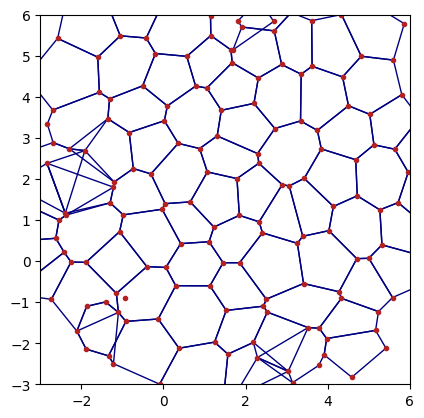

In [50]:
def get_animation(cells, vertices):
    fig, ax = plt.subplots()
    ax.set_xlim(-3, 6)
    ax.set_ylim(-3, 6)
    ax.set_aspect('equal')

    def init():
        ax.clear()
        ax.set_xlim(-3, 6)
        ax.set_ylim(-3, 6)
        ax.set_aspect('equal')
        return []

    def update(frame):  
        ax.clear()
        ax.set_xlim(-3, 6)
        ax.set_ylim(-3, 6)
        ax.set_aspect('equal')

        for i in range(display_interval):
            update_positions_and_velocities()
        draw_v_pairs = []
        for c in cells:
            draw_v_pairs += ([[c.v[i], c.v[i+1]] for i in range(len(c.v)-1)])
            draw_v_pairs.append([c.v[-1], c.v[0]])
        lines = [ax.plot([], [], '-', linewidth = 1, markersize = 0, color = "navy")[0] for _ in range(len(draw_v_pairs))]
        points = [ax.plot([], 'o', markersize = 3, color = "firebrick")[0] for _ in range(len(vertices))]

        line_i = 0
        point_i = 0
        for v in vertices:
            points[point_i].set_data(v.x[0], v.x[1])
            point_i += 1
        for c in cells:
            draw_v_pairs = ([[c.v[i], c.v[i+1]] for i in range(len(c.v)-1)])
            draw_v_pairs.append([c.v[-1], c.v[0]])
            for pair in draw_v_pairs:
                p1 = vertices[pair[0]].x
                p2 = vertices[pair[1]].x
                lines[line_i].set_data([p1[0], p2[0]], [p1[1], p2[1]])
                line_i += 1
        return lines + points  # return the updated artists
        
        
    num_frames = 100  # Number of frames for animation
    ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval = h*1e4*display_interval)
    return ani

ani = get_animation(cells, vertices)
HTML(ani.to_jshtml())


In [15]:
ani.save('animation_c7_inh_div.mp4', writer='ffmpeg')

KeyboardInterrupt: 

IndexError: list index out of range

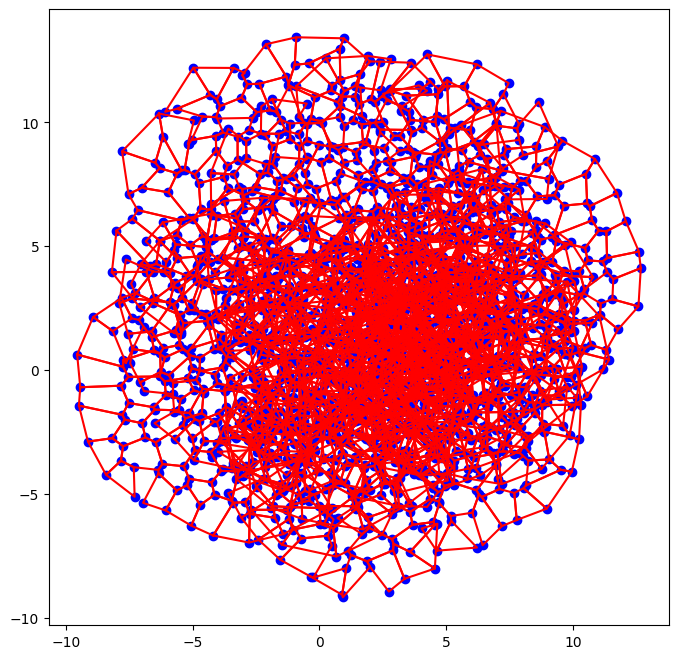

In [8]:
# Draw vertices
plt.figure(figsize=(8, 8))
for v in vertices:
    plt.scatter(*v.x, color='blue')

# Draw cells
for c in cells:
    cell_vertices = [vertices[i].x for i in c.v]
    cell_vertices.append(cell_vertices[0])  # close the cell by connecting to the first vertex
    cell_vertices = np.array(cell_vertices)
    plt.plot(cell_vertices[:, 0], cell_vertices[:, 1], color='red')

# Show the plot
plt.axis('equal')  # ensures that the scale is the same on both axes
plt.show()